In [1]:
from PepitoDataset import LimitedPepitoDataset
from Models import PepitoModel
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np

# Data

In [2]:
# Load the dataset
dataset = LimitedPepitoDataset("./yolo_results.json", "cat_detected")

# Split the dataset into train and test and create the dataloaders
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0)

# Save the split indexes to reproduce the same split later
np.save("train_indexes_limited.npy", train_dataset.indices)
np.save("test_indexes_limited.npy", test_dataset.indices)

# Model

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Assuming PepitoModel, train_dataloader, and test_dataloader are already defined

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PepitoModel(2).to(device)  # Output layer should have 2 neurons for two classes
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight decay for regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

/home/tsauv/Dev/pepito/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tsauv/Dev/pepito/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/tsauv/Dev/pepito/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [4]:
def train():
    print("Training")
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    tqdm_train_dataloader = tqdm(train_dataloader)
    for i, (inputs, _, labels) in enumerate(tqdm_train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        
        tqdm_train_dataloader.set_postfix(loss=running_loss / (i + 1))

    print(f"Training Accuracy: {100 * correct / total:.2f}%")


def test():
    print("Testing")
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        tqdm_test_dataloader = tqdm(test_dataloader)
        for i, (inputs, _, labels) in enumerate(tqdm_test_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            tqdm_test_dataloader.set_postfix(loss=running_loss / (i + 1))
    accuracy = 100 * correct / total
    print(f"Testing Accuracy: {accuracy:.2f}%")
    return running_loss, accuracy


for epoch in range(5):
    print(f"Epoch {epoch + 1}")
    train()
    val_loss, val_accuracy = test()
    scheduler.step(val_loss)  # Adjust learning rate based on validation loss
    print("--------------------------------------------------")

torch.save(model.state_dict(), f"limited_set.pt")

Epoch 1
Training


100%|██████████| 378/378 [01:12<00:00,  5.20it/s, loss=0.334]


Training Accuracy: 83.69%
Testing


100%|██████████| 95/95 [00:11<00:00,  8.27it/s, loss=0.0324]


Testing Accuracy: 99.47%
--------------------------------------------------
Epoch 2
Training


100%|██████████| 378/378 [01:07<00:00,  5.61it/s, loss=0.735]


Training Accuracy: 55.56%
Testing


100%|██████████| 95/95 [00:10<00:00,  9.12it/s, loss=0.688]


Testing Accuracy: 55.29%
--------------------------------------------------
Epoch 3
Training


100%|██████████| 378/378 [01:06<00:00,  5.68it/s, loss=0.686]


Training Accuracy: 56.33%
Testing


100%|██████████| 95/95 [00:08<00:00, 11.37it/s, loss=0.688]


Testing Accuracy: 55.29%
--------------------------------------------------
Epoch 4
Training


100%|██████████| 378/378 [01:05<00:00,  5.79it/s, loss=0.687]


Training Accuracy: 56.30%
Testing


100%|██████████| 95/95 [00:09<00:00,  9.56it/s, loss=0.687]


Testing Accuracy: 55.29%
--------------------------------------------------
Epoch 5
Training


100%|██████████| 378/378 [01:05<00:00,  5.81it/s, loss=0.69] 


Training Accuracy: 56.32%
Testing


100%|██████████| 95/95 [00:07<00:00, 12.12it/s, loss=0.687]


Testing Accuracy: 55.29%
--------------------------------------------------


/home/tsauv/Dev/pepito/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tsauv/Dev/pepito/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


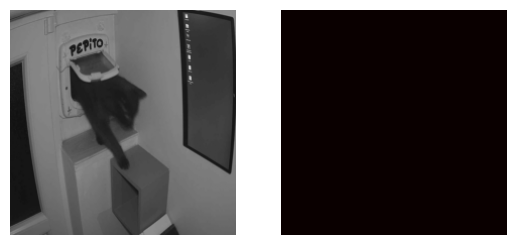

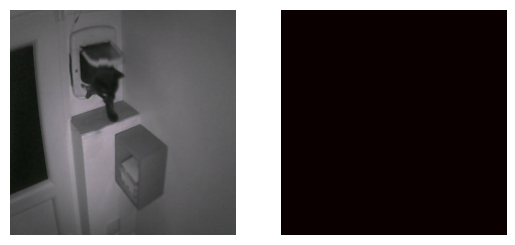

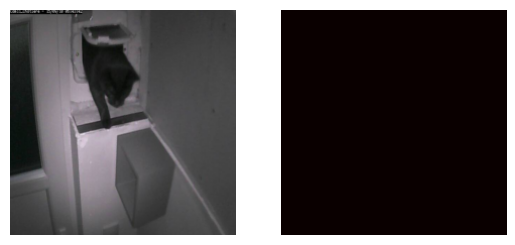

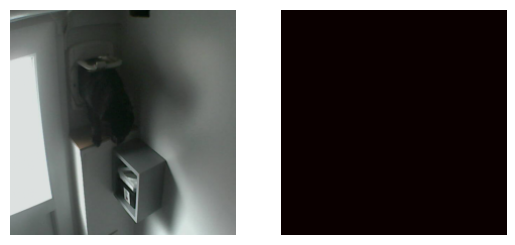

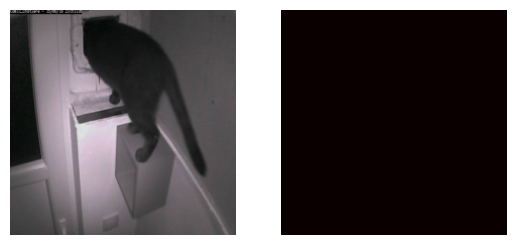

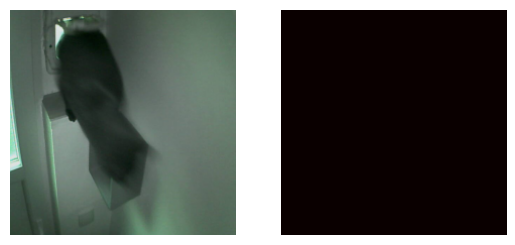

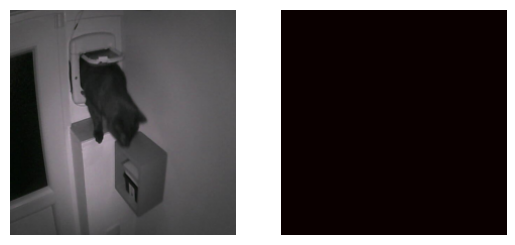

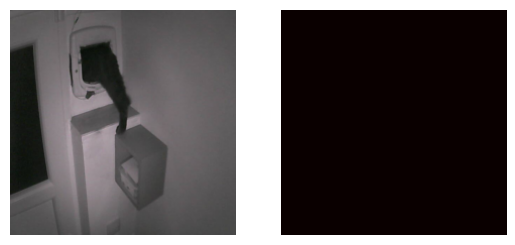

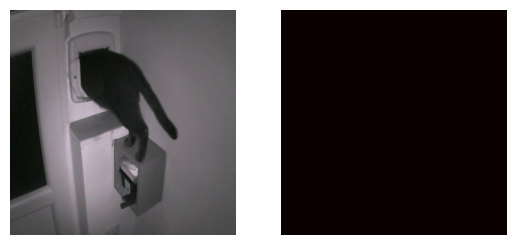

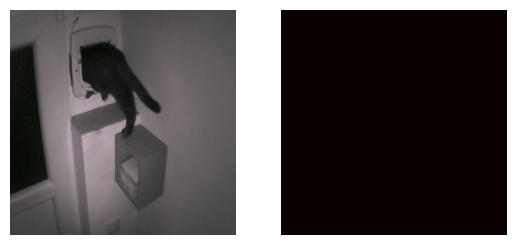

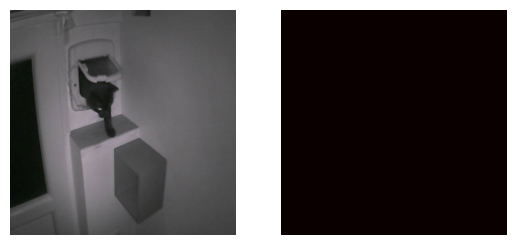

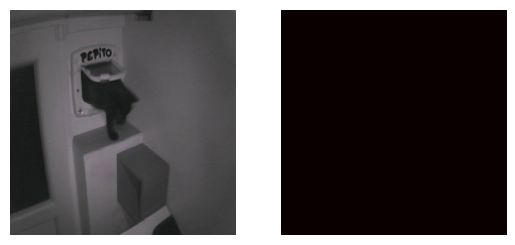

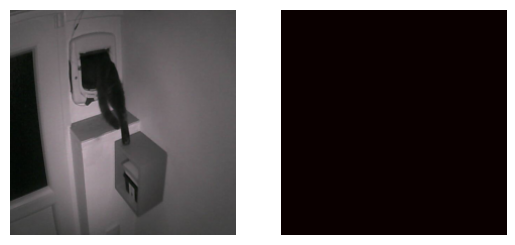

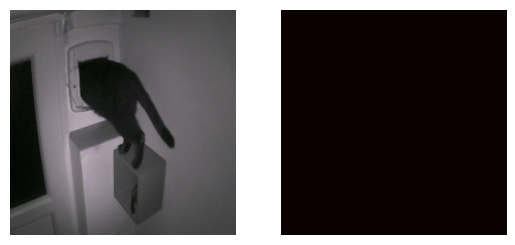

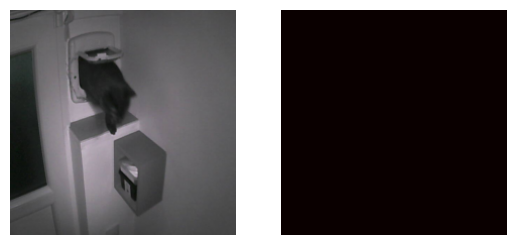

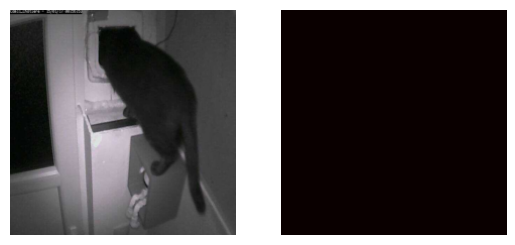

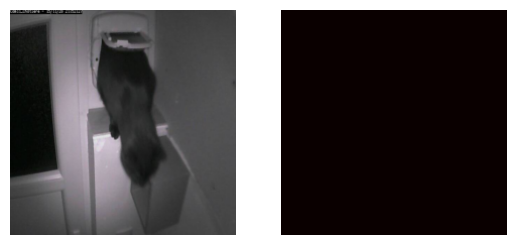

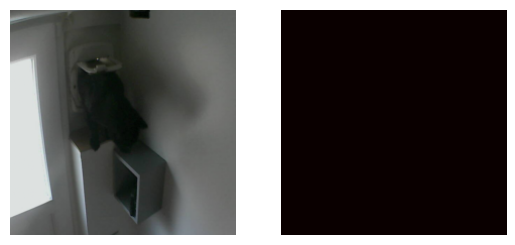

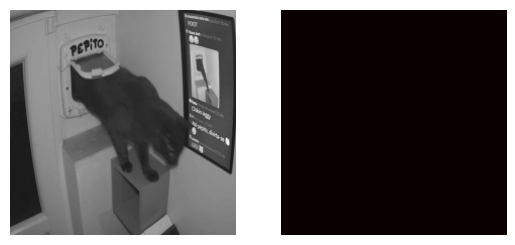

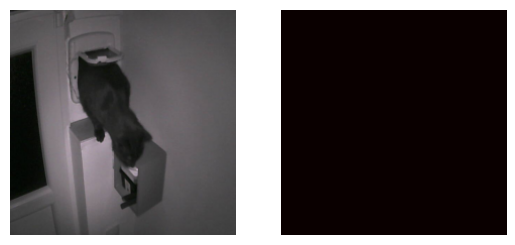

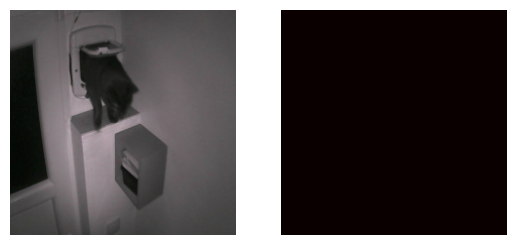

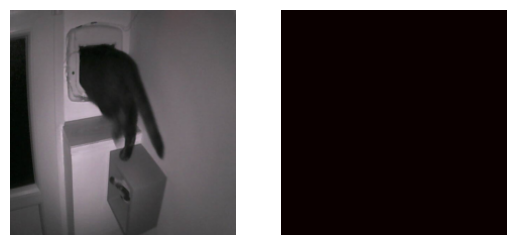

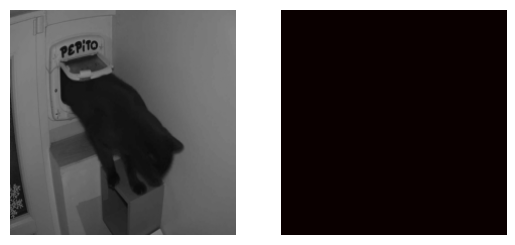

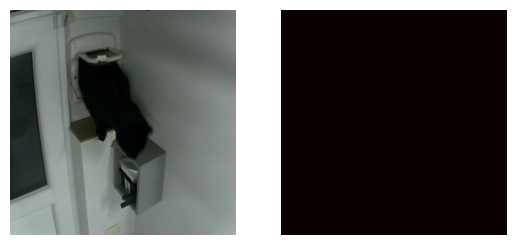

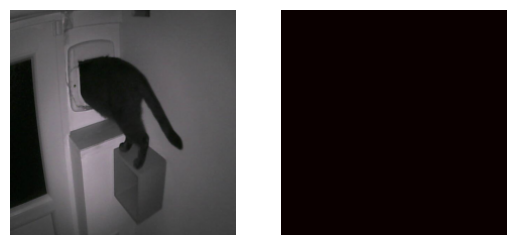

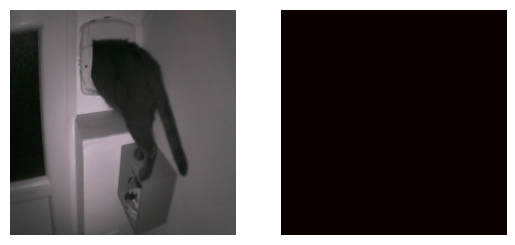

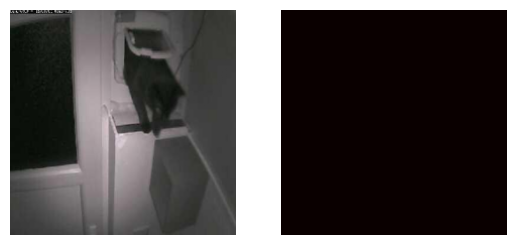

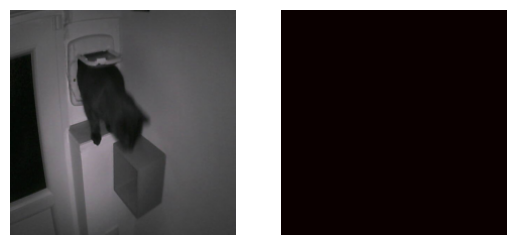

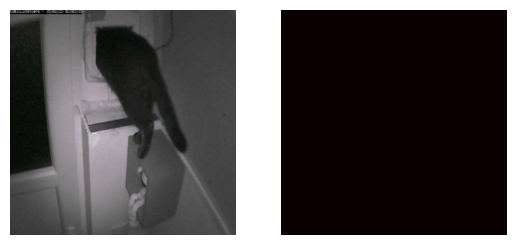

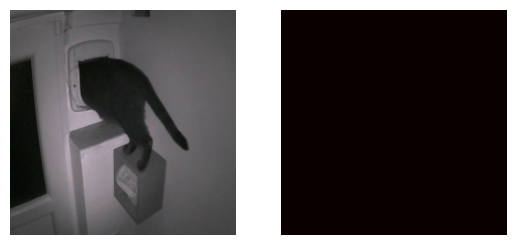

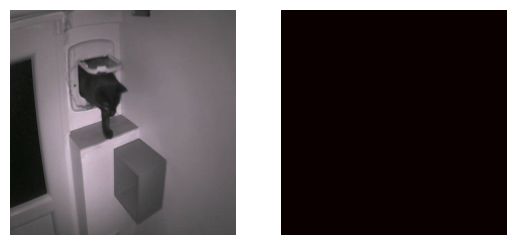

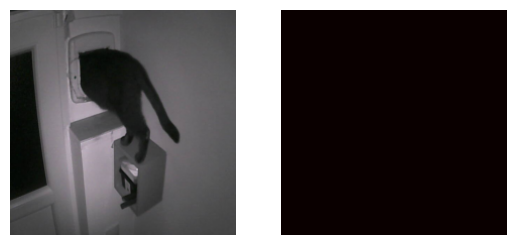

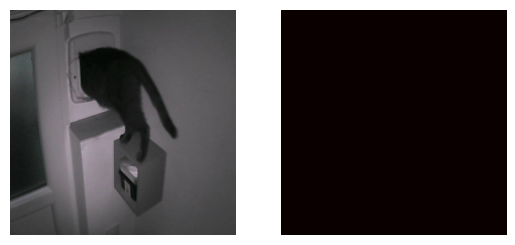

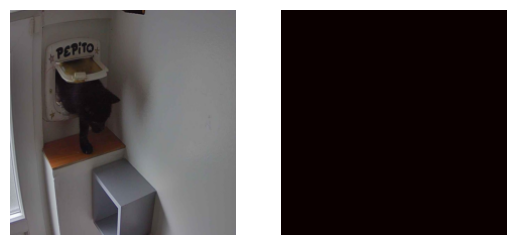

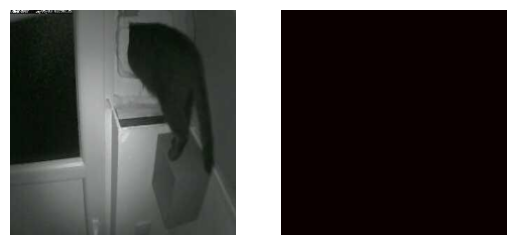

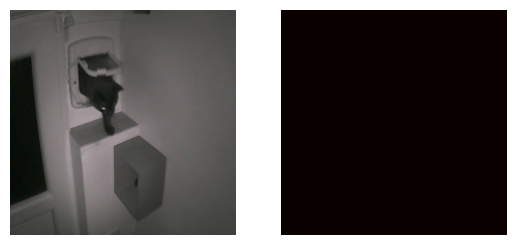

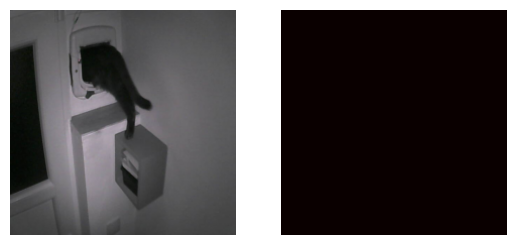

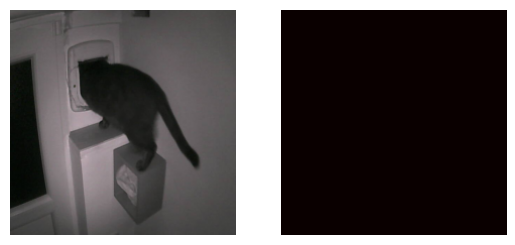

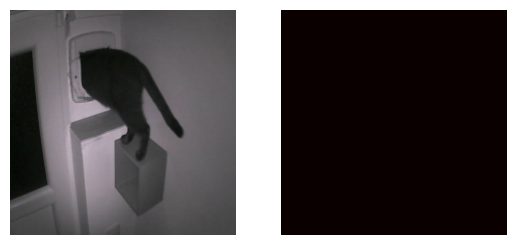

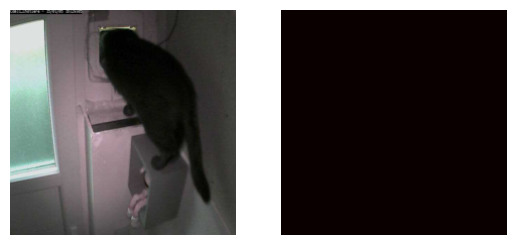

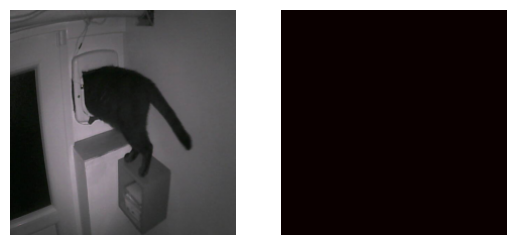

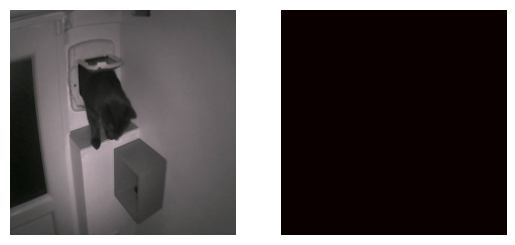

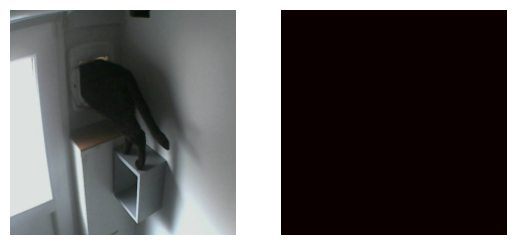

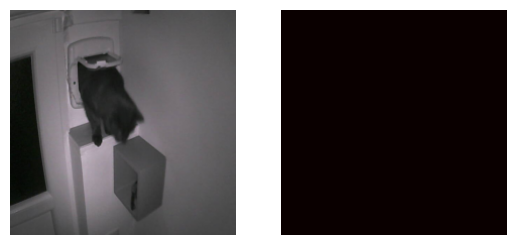

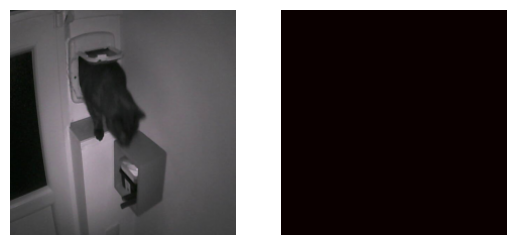

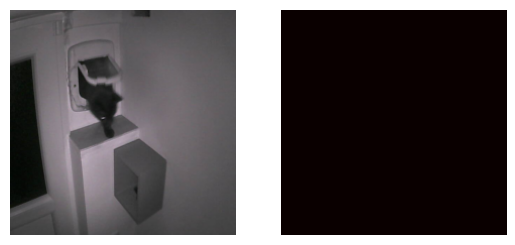

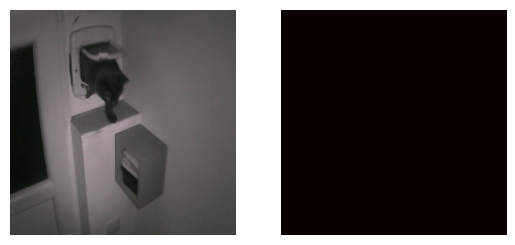

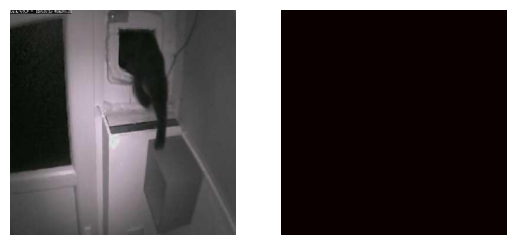

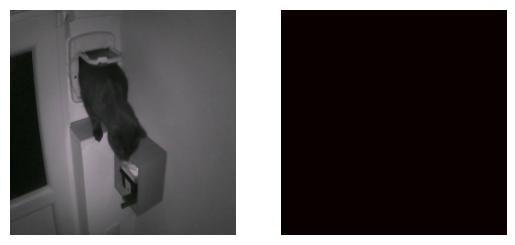

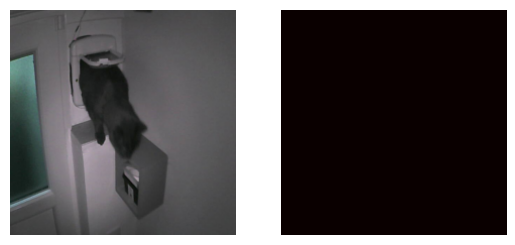

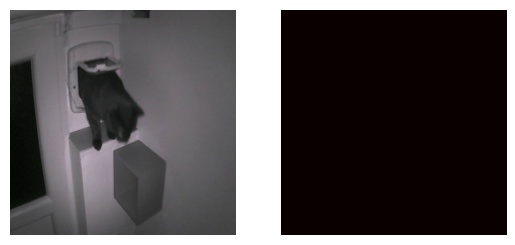

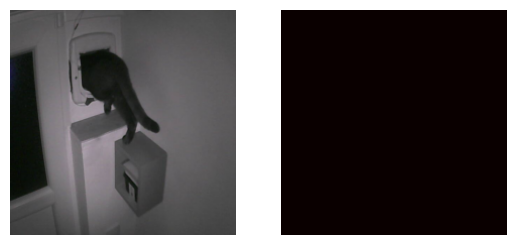

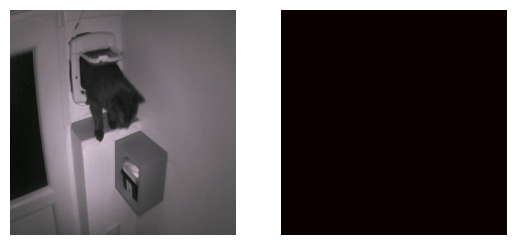

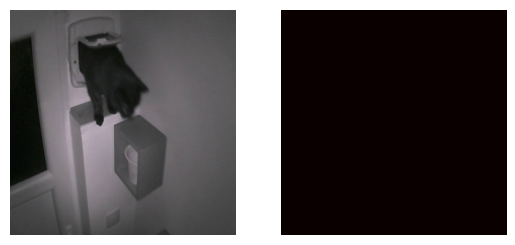

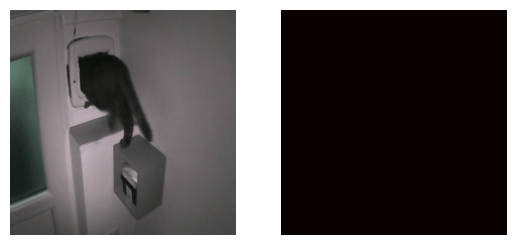

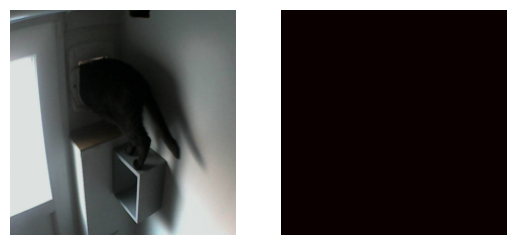

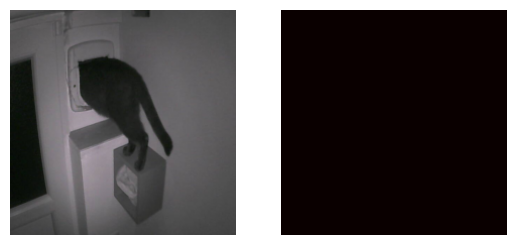

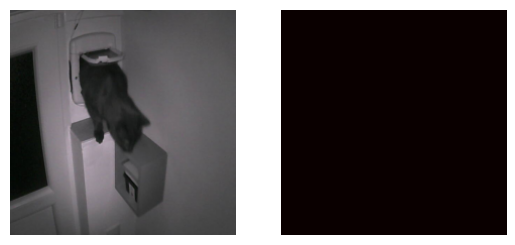

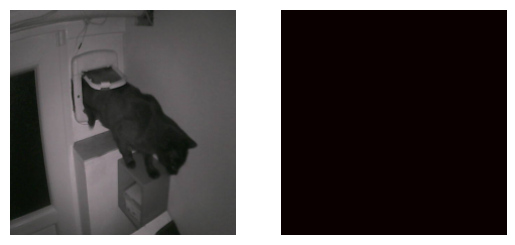

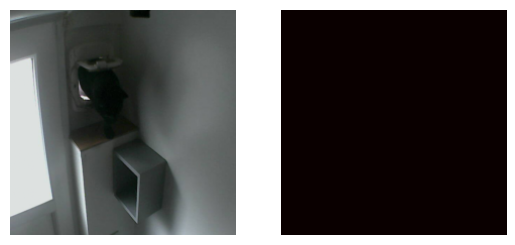

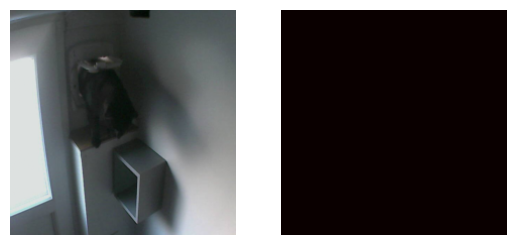

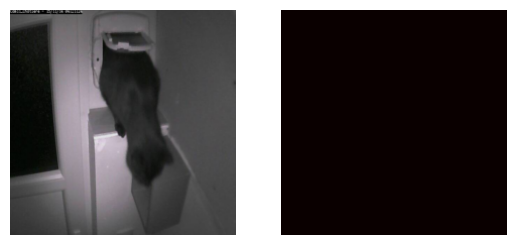

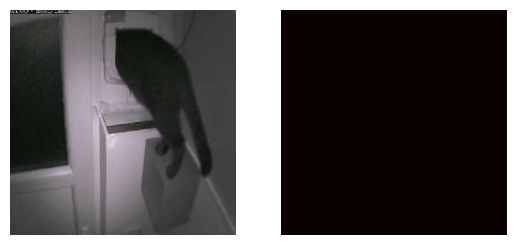

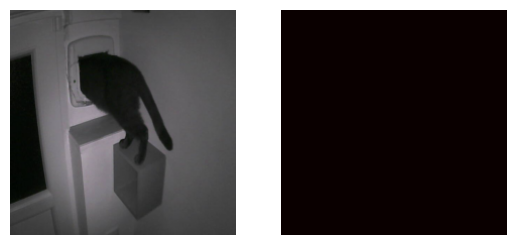

In [5]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def compute_saliency_maps(X, y, model):
    model.eval()
    X.requires_grad_()
    scores = model(X)
    score_max_index = scores.argmax(dim=1)
    score_max = scores[:, score_max_index]
    score_max.backward(torch.ones_like(score_max))
    saliency, _ = torch.max(X.grad.data.abs(), dim=1)
    return saliency

def show_saliency_maps(data_loader, model):
    model.eval()
    for i, data in enumerate(data_loader):
        inputs, _, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        saliency = compute_saliency_maps(inputs, labels, model)
        saliency = saliency.cpu().numpy()
        for j in range(inputs.size(0)):
            plt.subplot(1, 2, 1)
            plt.imshow(inputs[j].detach().cpu().permute(1, 2, 0))
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(saliency[j], cmap=plt.cm.hot)
            plt.axis('off')
            plt.show()
        if i == 1:
            break

model = PepitoModel(2).to(device)
model.load_state_dict(torch.load("limited_set.pt"))
show_saliency_maps(test_dataloader, model)

# Analysis

In [6]:
from PepitoDataset import PepitoDataset
from Models import PepitoModel
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from ultralytics import YOLO

# Load the dataset
dataset = LimitedPepitoDataset("./yolo_results.json", "cat_detected")

# Split the dataset into train and test from the saved indexes
train_indexes = np.load("train_indexes_limited.npy")
test_indexes = np.load("test_indexes_limited.npy")
train_dataset = torch.utils.data.Subset(dataset, train_indexes)
test_dataset = torch.utils.data.Subset(dataset, test_indexes)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0)

# Assuming PepitoModel, train_dataloader, and test_dataloader are already defined

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the models
model = PepitoModel(2).to(device)  # Output layer should have 2 neurons for two classes
box_model = YOLO("yolo11n.pt").to(device)  # load an official model

/home/tsauv/Dev/pepito/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tsauv/Dev/pepito/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


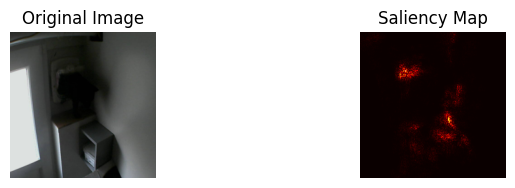

--------------------------------------------------


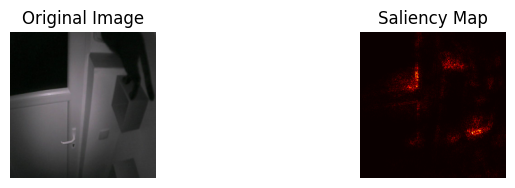

--------------------------------------------------


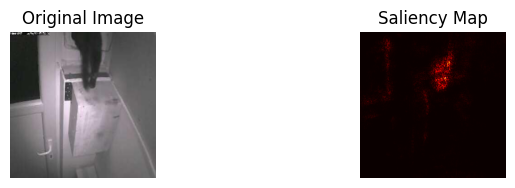

--------------------------------------------------


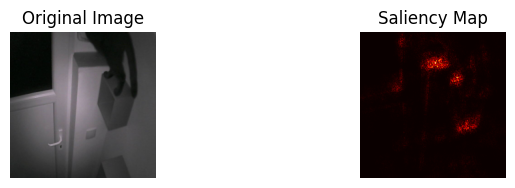

--------------------------------------------------


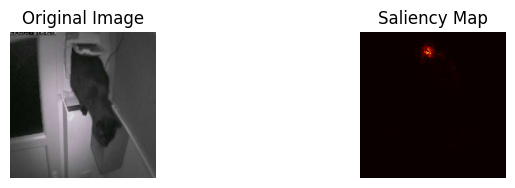

--------------------------------------------------


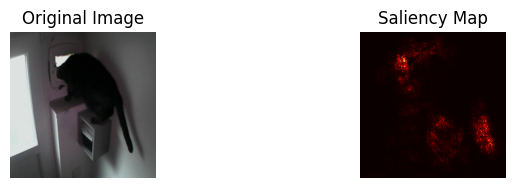

--------------------------------------------------


In [7]:
from PepitoDataset import LABEL_MAP
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms

reversed_label_map = {v: k for k, v in LABEL_MAP.items()}
model.load_state_dict(torch.load("final_model_random.pt"))
model.eval()

total = 0

misclassified = 0

for i, data in enumerate(test_dataloader):
    inputs, _, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)

    for j in range(inputs.size(0)):
        total += 1
        if predicted[j] != labels[j]:
            misclassified += 1
            # Compute saliency map
            saliency = compute_saliency_maps(inputs[j].unsqueeze(0), labels[j].unsqueeze(0), model)
            saliency = saliency.cpu().numpy()

            # Convert tensor to numpy array and denormalize
            img = inputs[j].detach().cpu().permute(1, 2, 0).numpy()
            img = (img * 255).astype(np.uint8)

            # Plot original image
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title("Original Image")


            # Plot saliency map
            plt.subplot(1, 3, 3)
            plt.imshow(saliency[0], cmap=plt.cm.hot)
            plt.axis('off')
            plt.title("Saliency Map")

            plt.show()

            print("--------------------------------------------------")

In [8]:
print(f"Misclassified: {misclassified}/{total}")
print(f"Accuracy: {(total - misclassified) / total * 100:.2f}%")

Misclassified: 6/3017
Accuracy: 99.80%
